In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

# ТОРГОВЫЙ АЛГОРИТМ

In [9]:
total_df = pd.read_csv('total_df.csv',index_col='df_index')\
    .rename(columns={'Price':'actual_return','pred':'predicted_return','lower':'lower_ci','upper':'upper_ci'})

In [10]:
total_df

,actual_return,lower_ci,predicted_return,upper_ci,prob_of_growth,ticker
df_index,,,,,,
2019-08-01,-0.020051,-0.133287,0.005932,0.145150,0.533276,ГАЗПРОМ ао
2019-09-01,-0.026922,-0.132970,0.005693,0.144357,0.532069,ГАЗПРОМ ао
2019-10-01,0.150952,-0.132769,0.005397,0.143562,0.530512,ГАЗПРОМ ао
2019-11-01,-0.009462,-0.133450,0.006708,0.146866,0.537368,ГАЗПРОМ ао
2019-12-01,-0.004426,-0.132999,0.006564,0.146126,0.536721,ГАЗПРОМ ао
...,...,...,...,...,...,...
2023-03-01,-0.022434,-0.320876,-0.034066,0.252743,0.407959,FIXP-гдр
2023-04-01,0.011474,-0.303213,-0.022398,0.258418,0.437888,FIXP-гдр
2023-05-01,0.032048,-0.306941,-0.031478,0.243985,0.411389,FIXP-гдр


# ТОРГОВЫЙ АЛГОРИТМ

In [11]:
trading_days = total_df.index.unique() #Набор торговых дней с предсказаниями и фактами
bank = 1000 #Сумма денег на моём счету , которые я вкладываю . Это не накопленная стоимость портфеля 
portfolio = {} #Ключ - актив , значение - накопленный по нему доход
grow_hit = 0 #Подсчёт попаданий на росте
fall_hit = 0 #Подсчёт попаданий на падении
miss = 0 #Подсчёт промахов и на росте и на падении
hit_list = [] 
miss_list = [] 
fall_miss_ratio = []
capital = [] #Сумма денег в портфеле и банке которую в корце визуализирую

In [12]:
for day in trading_days:
    #Устанавливаем активы , которые вносим в списки потенциального роста и потенциального падения
    good_assets = total_df.loc[day].query('prob_of_growth > 0.7').ticker.values
    bad_assets = total_df.loc[day].query('prob_of_growth < 0.3').ticker.values
    
    #Продаём активы , которые остались с прошлой итерации , но больше нам не интересны
    for asset in list(portfolio):
        if asset not in good_assets :
            bank+=portfolio[asset]
            del portfolio[asset]

    #Продаём активы из зоны падения и возвращаем полученные деньги в банк
    for asset in bad_assets: 
        if asset in list(portfolio):
            bank+=portfolio[asset]
            del portfolio[asset]
        #Проверяем угадали ли направление
        if 1 > (1 + total_df.loc[total_df.ticker == asset].loc[day][0]):#1+реальная доходность
            fall_hit+=1
        elif 1 < (1 + total_df.loc[total_df.ticker == asset].loc[day][0]):
            miss+=1
    
    
    #Определяем разер вложений.Если банк=0,то для формальности вкладываем 0.01,что бы узнать угадали ли направление
    if bank != 0 :
        invest_ammout = bank/len(good_assets)#вкладываем весь банк равномерно 
    elif bank == 0 : 
        invest_ammout = 0.01
    
    #Покупаем активы из зоны роста
    for asset in good_assets: 
        if asset not in list(portfolio): #Если его нет в портфеле ,то добавляем его
            portfolio[asset] = (invest_ammout)*(1 + total_df.loc[total_df.ticker == asset].loc[day][0])#(1+real_ret)
            bank -= invest_ammout
            #Проверка угадано ли направление доходности
            if 1 < (1 + total_df.loc[total_df.ticker == asset].loc[day][0]):
                grow_hit+=1
            elif 1 > (1 + total_df.loc[total_df.ticker == asset].loc[day][0]):
                miss+=1
        elif asset in list(portfolio): #Если такой актив уже есть
            portfolio[asset] += invest_ammout #Прибавляем к уже имеющимся вложениям а затем умножем на 1+real return
            portfolio[asset] = portfolio[asset] * (1 + total_df.loc[total_df.ticker == asset].loc[day][0])
            bank -= invest_ammout
            #Проверка угадано ли направление доходности
            if 1 < (1 + total_df.loc[total_df.ticker == asset].loc[day][0]):
                grow_hit+=1
            elif 1 > (1 + total_df.loc[total_df.ticker == asset].loc[day][0]):
                miss+=1 
        
        print(f"В актив { asset } вложил { invest_ammout } и получил {(invest_ammout)*(1 + total_df.loc[total_df.ticker == asset].loc[day][0])}")    
        
#Пополняю списки попаданий и промахов в конце каждого дня
    hit_list.append(grow_hit+fall_hit)
    miss_list.append(miss)
    fall_miss_ratio.append( (grow_hit+fall_hit)/miss )
    capital.append( bank+(sum(portfolio[x] for x in portfolio)) )
#____________________ИНФОРМАЦИОННОЕ ОКНО_____________________   
    if len(list(portfolio)) == 0 :
        print(f"В день {day} ничего не покупалось")
    print(f"Банк {bank}")
    print(f"Портфель на момент {day} : {list(portfolio)}")
    print(f"Накопленная доходность портфеля : {sum(portfolio[x] for x in portfolio)}")
    print(f"Угаданных направлений: {grow_hit+fall_hit}")
    print(f"Негаданных направлений: {miss}")
    print('___________________________\n')

В актив Новатэк ао вложил 500.0 и получил 488.0266747499242
В актив Сургнфгз-п вложил 500.0 и получил 517.742453436095
Банк 0.0
Портфель на момент 2019-08-01 : ['Новатэк ао', 'Сургнфгз-п']
Накопленная доходность портфеля : 1005.7691281860193
Угаданных направлений: 1
Негаданных направлений: 1
___________________________

В день 2019-09-01 ничего не покупалось
Банк 1005.7691281860193
Портфель на момент 2019-09-01 : []
Накопленная доходность портфеля : 0
Угаданных направлений: 1
Негаданных направлений: 2
___________________________

В актив Татнфт 3ап вложил 1005.7691281860193 и получил 1057.6062796786127
Банк 0.0
Портфель на момент 2019-10-01 : ['Татнфт 3ап']
Накопленная доходность портфеля : 1057.6062796786127
Угаданных направлений: 2
Негаданных направлений: 4
___________________________

В день 2019-11-01 ничего не покупалось
Банк 1057.6062796786127
Портфель на момент 2019-11-01 : []
Накопленная доходность портфеля : 0
Угаданных направлений: 2
Негаданных направлений: 5
________________

### Динамика угаданных и неугаданных направлений

Text(0.5, 1.0, 'Синяя линия - угаданные направления , красная линия - промахи')

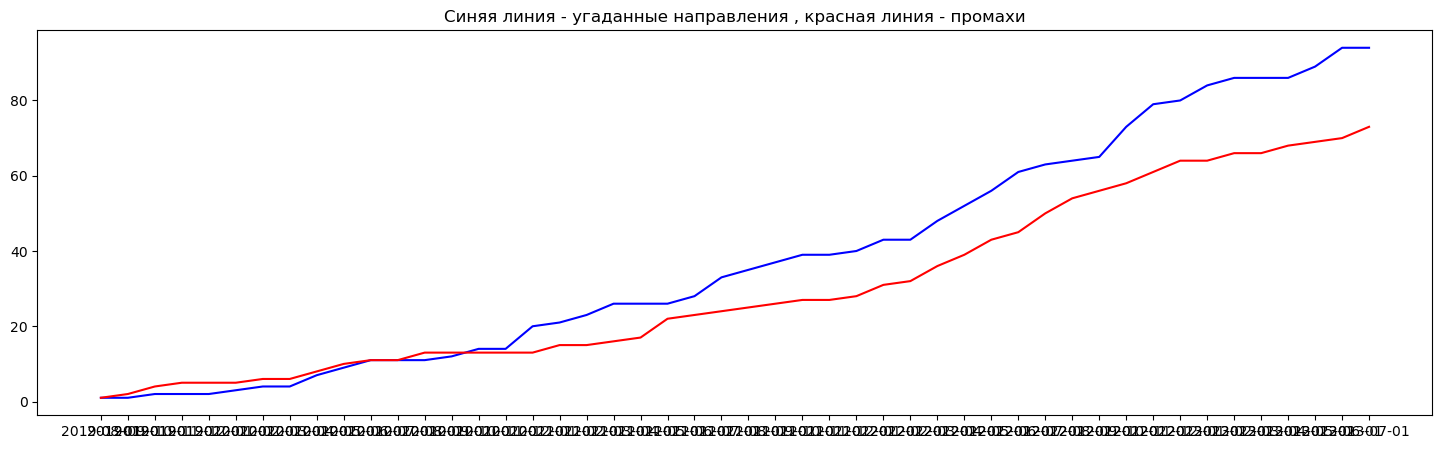

In [13]:
plt.rcParams["figure.figsize"] = 18, 5
plt.plot(pd.DataFrame(hit_list).set_index(trading_days) ,color='blue')
plt.plot(pd.DataFrame(miss_list).set_index(trading_days),color='red'  )
plt.title('Синяя линия - угаданные направления , красная линия - промахи')

### Динамика коэффициента отношения hit/miss

Text(0.5, 1.0, 'Отношение hit/miss')

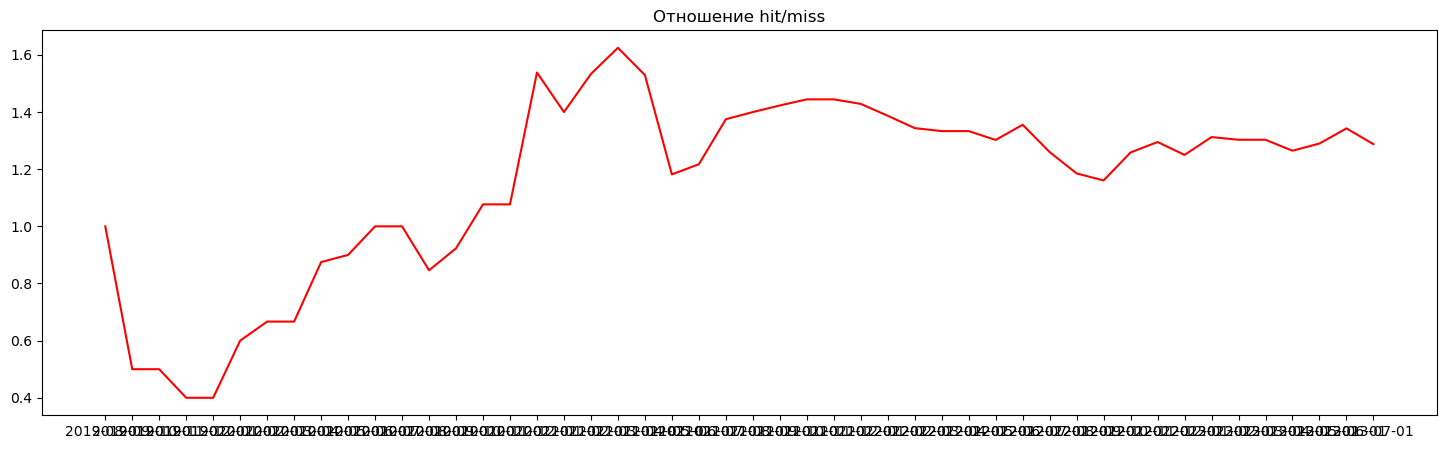

In [14]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(pd.DataFrame(fall_miss_ratio).set_index(trading_days),color='red'  )
plt.title('Отношение hit/miss')

### Динамика общего капитала(деньги в банке+портфеле)

Text(0.5, 1.0, 'Общий капитал')

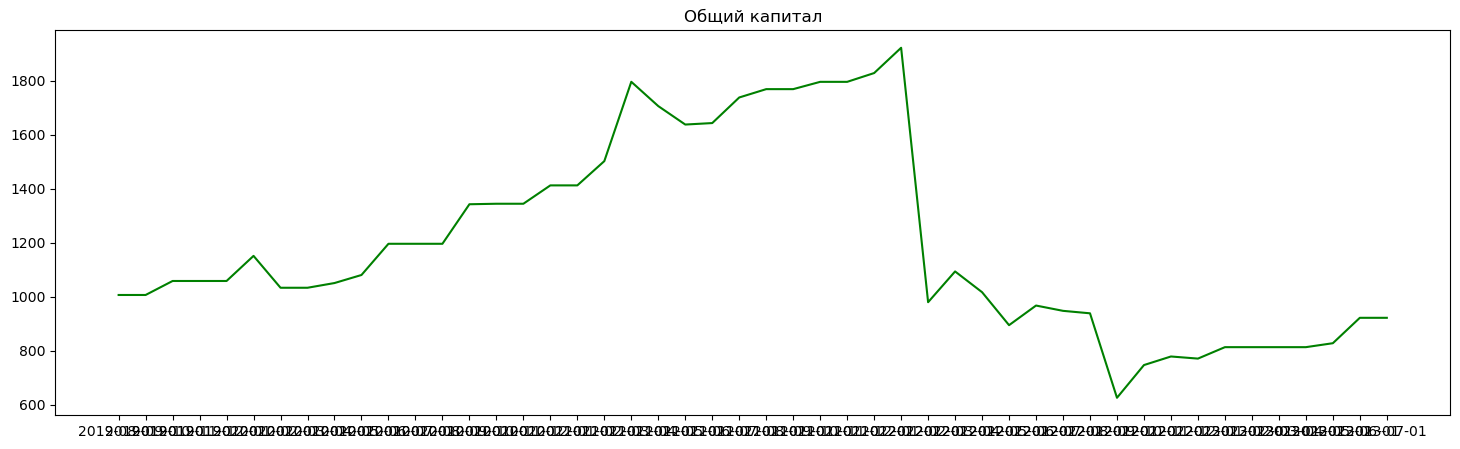

In [15]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(pd.DataFrame(capital).set_index(trading_days),color='green'  )
plt.title('Общий капитал')

### Сильное падение накопленного капитала (с 1900 до 970 рублей) приходится на период с 01.01.2022 по 01.02.2022 . Упали акции группы ПИК